# Brain MRI Tumor Classification 
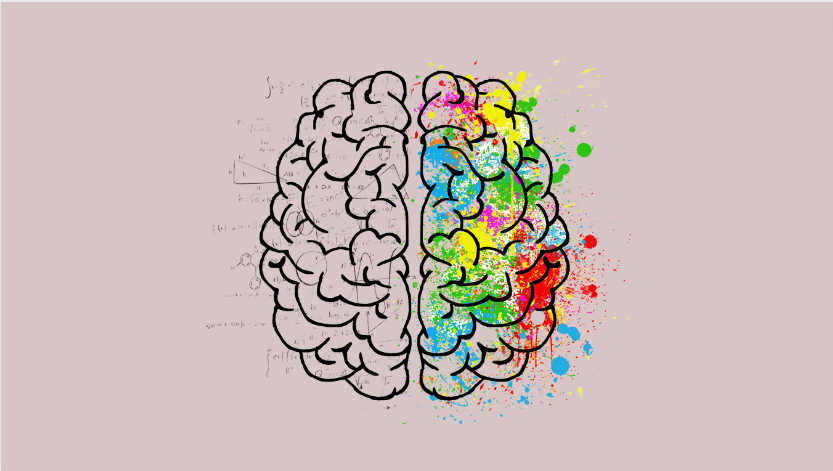


## Introduction
#### In this notebook, I'll use a Convolutional Neural Network (CNN) to perform Image Classification on Brain Tumor MRI images.

In [65]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from keras import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [66]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

## Load and prep data

In [67]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    folderPath = os.path.join('data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 195.77it/s]


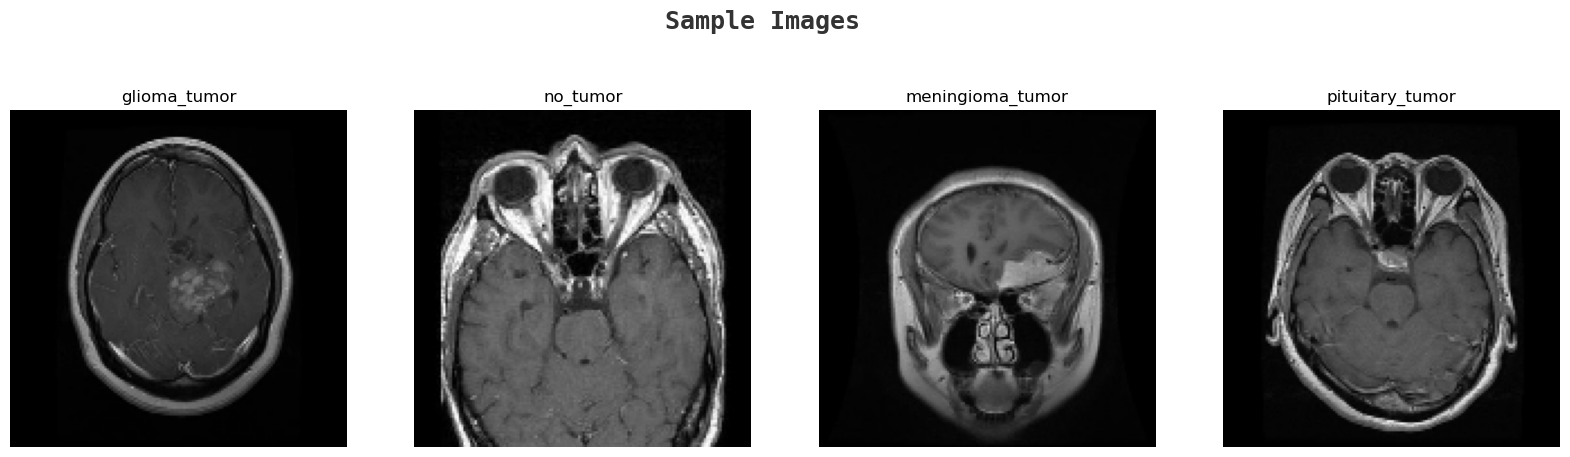

In [73]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='       Sample Images',
         size=18,
         fontweight='bold',
         fontname='monospace',
         # color=colors_dark[1],
         y=0.62,
         x=0.4,
         alpha=0.8
        )

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

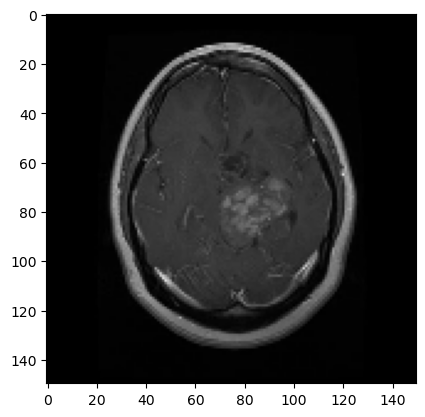

In [49]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.show()

 Split data for training and testing

In [74]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20)

One hot encode target values

In [76]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [81]:
X_train.shape

(2937, 150, 150, 3)

In [104]:
# save data to .npy file 
np.save('saves/data/x_train.npy', X_train)
np.save('saves/data/x_test.npy', X_test)

np.save('saves/data/y_train.npy', y_train)
np.save('saves/data/y_test.npy', y_test)

---
## Model Building
### Convolutional Neural Networks are great for computer image problems, as they break down and generalize/learn from pixel images

---

Building simple baseline CNN with few layers

In [52]:
cnn = Sequential([
        # ccn network
        Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        # dense network
        Flatten(),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
])

In [53]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
           )

In [54]:
cnn.fit(X_train, y_train, validation_split=0.1, epochs=10, verbose=1, batch_size=32)

Epoch 1/10
83/83 [==============================] - 24s 281ms/step - loss: 43.7349 - accuracy: 0.4521 - val_loss: 0.8135 - val_accuracy: 0.6905
Epoch 2/10
83/83 [==============================] - 25s 304ms/step - loss: 0.5686 - accuracy: 0.8017 - val_loss: 0.5642 - val_accuracy: 0.8061
Epoch 3/10
83/83 [==============================] - 25s 305ms/step - loss: 0.2227 - accuracy: 0.9236 - val_loss: 0.4822 - val_accuracy: 0.8503
Epoch 4/10
83/83 [==============================] - 25s 304ms/step - loss: 0.0983 - accuracy: 0.9731 - val_loss: 0.6686 - val_accuracy: 0.8571
Epoch 5/10
83/83 [==============================] - 25s 305ms/step - loss: 0.0398 - accuracy: 0.9909 - val_loss: 0.6389 - val_accuracy: 0.8639
Epoch 6/10
83/83 [==============================] - 25s 305ms/step - loss: 0.0317 - accuracy: 0.9943 - val_loss: 0.7002 - val_accuracy: 0.8571
Epoch 7/10
83/83 [==============================] - 25s 305ms/step - loss: 0.0467 - accuracy: 0.9909 - val_loss: 0.5191 - val_accuracy: 0.863

---
Save model for re-use

In [55]:
save_path = './base_model.h5'
cnn.save(save_path)

In [56]:
loaded_model = tf.keras.models.load_model(save_path)

In [57]:
y_pred = loaded_model.predict(X_test)

11/11 [==============================] - 1s 58ms/step


In [79]:
type(X_train)

numpy.ndarray

In [58]:
# y_pred = cnn.predict(X_test)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
y_pred = np.argmax(y_pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [61]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        82
           1       0.85      0.80      0.83        51
           2       0.87      0.78      0.82       102
           3       0.91      0.97      0.94        92

    accuracy                           0.86       327
   macro avg       0.86      0.86      0.86       327
weighted avg       0.86      0.86      0.86       327



---
Baseline network resulted in 81% accuracy which is not good enough for our purpose

We will need to use 'transfer learning' and load a state of the art pre-trained model,
to get a more accurate result while saving computational power/time on our local machine.